In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from fair import FAIR
from fair.interface import fill, initialise
from fair.io import read_properties

/home/conda/claire/53bcb309-1734634236-233-fair_analysis/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
f = FAIR(ch4_method="Thornhill2021")

In [3]:
f.define_time(1750, 2300, 1)  # start, end, step

In [4]:
scenarios = [
    "low",
   "instant-removal",
  "instant-removal-offsetting",
   "physical-delay",
 "physical-delay-offsetting",
    "accelerated-emissions",
 "accelerated-emissions-offsetting",
    "upfront-embodied",
    "upfront-embodied-offsetting",
]

In [5]:
f.define_scenarios(scenarios)

In [6]:
fair_params_1_4_1_file = 'data/calibrated_constrained_parameters_calibration1.4.1.csv'

In [7]:
df_configs = pd.read_csv(fair_params_1_4_1_file, index_col=0)
configs = df_configs.index  # this is used as a label for the "config" axis
f.define_configs(configs)

In [8]:
fair_species_configs_1_4_1_file = 'data/species_configs_properties_calibration1.4.1.csv'

In [9]:
species, properties = read_properties(filename=fair_species_configs_1_4_1_file)
f.define_species(species, properties)

In [10]:
f.allocate()

In [11]:
f.fill_from_csv(
    emissions_file='data/emissions.csv',
    forcing_file='data/volcanic.csv',
)

In [12]:
fill(
    f.forcing,
    f.forcing.sel(specie="Volcanic") * df_configs["forcing_scale[Volcanic]"].values.squeeze(),
    specie="Volcanic",
)
fill(
    f.forcing,
    f.forcing.sel(specie="Solar") * df_configs["forcing_scale[Solar]"].values.squeeze(),
    specie="Solar",
)

In [13]:
f.fill_species_configs(fair_species_configs_1_4_1_file)
f.override_defaults(fair_params_1_4_1_file)

In [14]:
initialise(f.concentration, f.species_configs["baseline_concentration"])
initialise(f.forcing, 0)
initialise(f.temperature, 0)
initialise(f.cumulative_emissions, 0)
initialise(f.airborne_emissions, 0)
initialise(f.ocean_heat_content_change, 0)

In [15]:
f.run()

Running 7569 projections in parallel: 100%|██████████| 550/550 [01:06<00:00,  8.25timesteps/s]


In [16]:
fancy_titles = {
    'low': 'Baseline',
    "instant-removal":"Instant Removal",
    "instant-removal-offsetting":"Instant Removal: Offsetting",
    "physical-delay":"Physical Delay",
    "physical-delay-offsetting":"Physical Delay: Offsetting",
    "accelerated-emissions":"Accelerated Emissions",
    "accelerated-emissions-offsetting":"Accelerated Emissions: Offsetting",
    "upfront-embodied":"Upfront Emissions",
    "upfront-embodied-offsetting":"Upfront Emissions: Offsetting",
}

colors = {
    'low': 'black',
    "instant-removal":"green",
    "instant-removal-offsetting":"green",
    "physical-delay":"blue",
    "physical-delay-offsetting":"blue",
    "accelerated-emissions":"red",
    "accelerated-emissions-offsetting":"red",
    "upfront-embodied":"purple",
    "upfront-embodied-offsetting":"purple",
}

linestyles = {
    'low': '-',
    "instant-removal":"-",
    "instant-removal-offsetting":"--",
    "physical-delay":"-",
    "physical-delay-offsetting":"--",
    "accelerated-emissions":"-",
    "accelerated-emissions-offsetting":"--",
    "upfront-embodied":"-",
    "upfront-embodied-offsetting":"--",
}

In [17]:
weights_51yr = np.ones(52)
weights_51yr[0] = 0.5
weights_51yr[-1] = 0.5

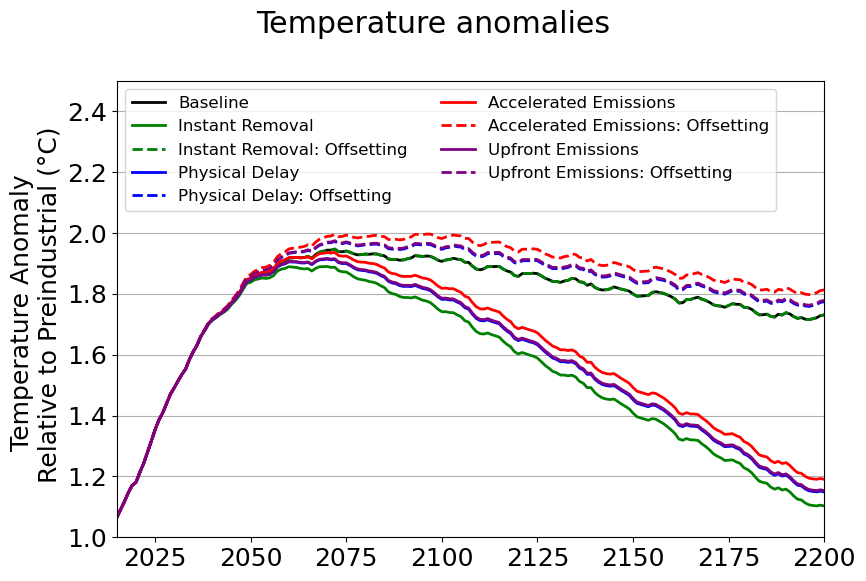

In [18]:
ncols=3
plt.rcParams['font.size'] = 18
fig = plt.figure(figsize=(9, 6))

for i, scenario in enumerate(scenarios):
    if scenario=='low':
        timebounds_start=0
    else:
        timebounds_start=250
    linewidth=2
    alpha=1
    plt.plot(
        f.timebounds[timebounds_start:],
        np.mean(
            f.temperature.loc[dict(scenario=scenario, layer=0)]
            - np.average(
                f.temperature.loc[
                    dict(scenario=scenario, timebounds=np.arange(1850, 1902), layer=0)
                ],
                #weights=weights_51yr,
                axis=0
            ),
            axis=1,
        )[timebounds_start:],
        color=colors[scenarios[i]],
        linestyle=linestyles[scenarios[i]],
        label=fancy_titles[scenarios[i]],
        linewidth=linewidth,
        alpha=alpha
    )
plt.xlim([2015, 2200])
plt.ylim([1.0, 2.5])
plt.axhline(0, color="k", ls=":", lw=0.5)
plt.legend(fontsize=12, loc='upper left', ncols=2)
plt.grid(axis='y')
plt.ylabel('Temperature Anomaly \n Relative to Preindustrial (°C)')

plt.suptitle("Temperature anomalies")
fig.tight_layout()
plt.savefig('figures/Temperature_anomalies_v2.pdf')

In [ ]:
ref=np.mean(
            f.temperature.loc[dict(scenario=scenario, layer=0)]
            - np.average(
                f.temperature.loc[
                    dict(scenario=scenario, timebounds=np.arange(1850, 1902), layer=0)
                ],
                #weights=weights_51yr,
                axis=0
            ),
            axis=1,
        )

In [ ]:
ncols=3
plt.rcParams['font.size'] = 18
fig = plt.figure(figsize=(9, 6))

for i, scenario in enumerate(scenarios):
    if scenario=='low':
        timebounds_start=0
    else:
        timebounds_start=250
    linewidth=2
    alpha=1
    plt.plot(
        f.timebounds[timebounds_start:],
        np.mean(
            f.temperature.loc[dict(scenario=scenario, layer=0)]
            - np.average(
                f.temperature.loc[
                    dict(scenario=scenario, timebounds=np.arange(1850, 1902), layer=0)
                ],
                #weights=weights_51yr,
                axis=0
            ),
            axis=1,
        )[timebounds_start:]-ref[timebounds_start:],
        color=colors[scenarios[i]],
        linestyle=linestyles[scenarios[i]],
        label=fancy_titles[scenarios[i]],
        linewidth=linewidth,
        alpha=alpha
    )
plt.xlim([2015, 2200])
plt.ylim([1.0, 2.5])
plt.axhline(0, color="k", ls=":", lw=0.5)
plt.legend(fontsize=12, loc='upper left', ncols=2)
plt.grid(axis='y')
plt.ylabel('Temperature Anomaly \n Relative to Preindustrial (°C)')

plt.suptitle("Temperature anomalies")
fig.tight_layout()
plt.savefig('figures/Temperature_anomalies_v2.pdf')

# Save data / load saved data

In [22]:
# Save temperature
f.temperature.to_netcdf("temperature.nc")

In [23]:
import xarray as xr
f.temperature = xr.open_dataset("temperature.nc").to_array()

/home/conda/claire/53bcb309-1734634236-233-fair_analysis/lib/python3.13/site-packages/xarray/namedarray/core.py:264: UserWarning: Duplicate dimension names present: dimensions {'variable'} appear more than once in dims=('variable', 'variable', 'timebounds', 'scenario', 'config', 'layer'). We do not yet support duplicate dimension names, but we do allow initial construction of the object. We recommend you rename the dims immediately to become distinct, as most xarray functionality is likely to fail silently if you do not. To rename the dimensions you will need to set the ``.dims`` attribute of each variable, ``e.g. var.dims=('x0', 'x1')``.
  self._dims = self._parse_dimensions(dims)


<xarray.DataArray (scenario: 9, config: 841)> Size: 61kB
array([[1.58968056, 1.78510452, 2.31691507, ..., 1.467342  , 1.72464516,
        2.3591564 ],
       [1.55630737, 1.7378853 , 2.24719081, ..., 1.44312485, 1.68507113,
        2.29162836],
       [1.58968056, 1.78510452, 2.31691507, ..., 1.467342  , 1.72464516,
        2.3591564 ],
       ...,
       [1.61781619, 1.83057163, 2.38068547, ..., 1.51132194, 1.75874454,
        2.45402794],
       [1.57275724, 1.75140517, 2.277894  , ..., 1.44943099, 1.70495975,
        2.31584015],
       [1.60589784, 1.81127995, 2.35364271, ..., 1.49213077, 1.74429302,
        2.4137714 ]], shape=(9, 841))
Coordinates:
  * scenario  (scenario) <U32 1kB 'low' ... 'upfront-embodied-offsetting'
  * config    (config) int64 7kB 1234 2451 5859 5883 ... 1592589 1594247 1597937
    layer     int64 8B 0

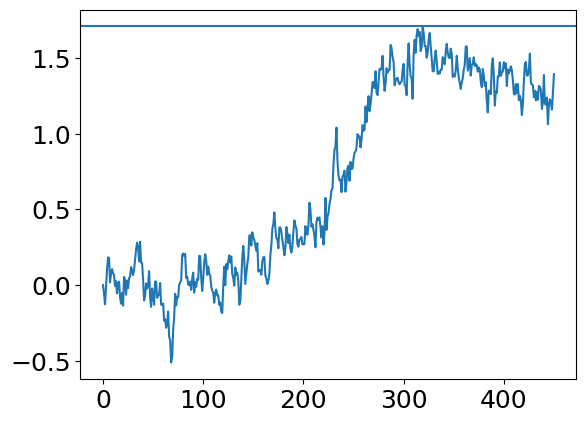

In [153]:
plt.plot(f.temperature[:451].sel(layer=0).rolling(timebounds=20)#..isel(scenario=0).isel(config=0))
plt.axhline(y=1.70811573)

/tmp/ipykernel_1157/2680201175.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(peak_temperatures, labels=peak_temperatures.columns)


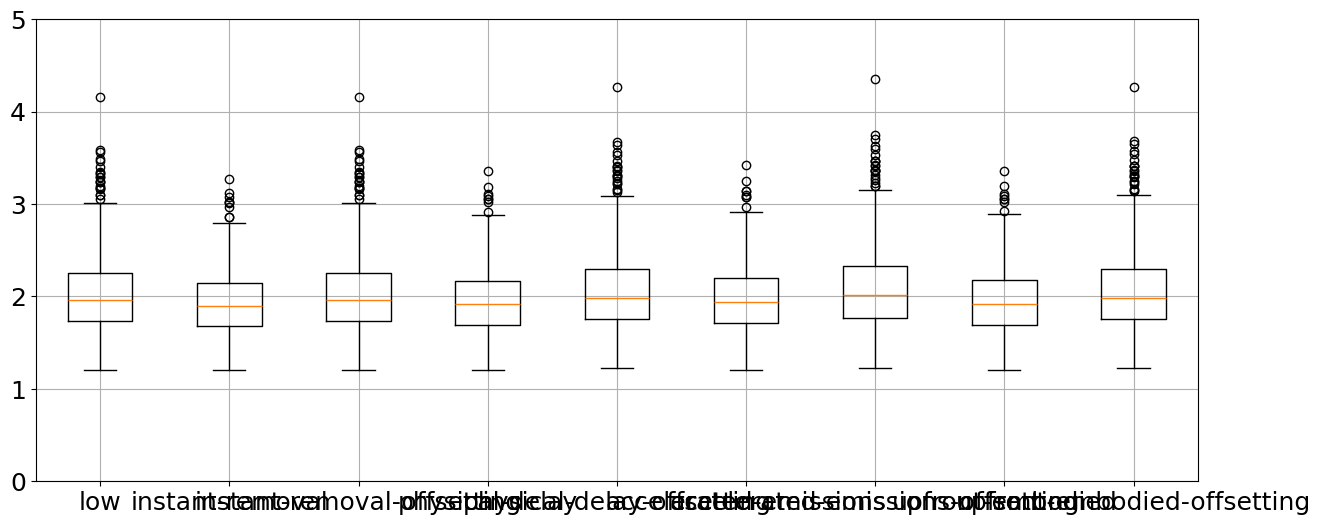

In [167]:
peak_temperatures = (f.temperature[:451].sel(layer=0).rolling(timebounds=20).mean().max(dim='timebounds')
                     - (np.average(
                f.temperature.loc[
                    dict(scenario=scenario, timebounds=np.arange(1850, 1902), layer=0)
                ]))).transpose().to_pandas()
peak_temperatures.to_csv('data/peak_temperatures.csv')

plt.figure(figsize=(15,6))
plt.boxplot(peak_temperatures, labels=peak_temperatures.columns)
plt.ylim([0,5])
plt.grid()

In [175]:


# New order of columns
new_order = ['low',  'instant-removal-offsetting',
             'physical-delay-offsetting', 
             'accelerated-emissions-offsetting',
             'upfront-embodied-offsetting',
             'instant-removal',
       'physical-delay', 
             'accelerated-emissions',
        'upfront-embodied',
       ]

# Reorder the DataFrame
peak_temperatures = peak_temperatures[new_order]

In [176]:
colors = ['black','green','blue','red','purple','green','blue','red','purple',]
alphas=[0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5]
hatches = ['', '\\\\', '\\\\', '\\\\','\\\\','','','','']

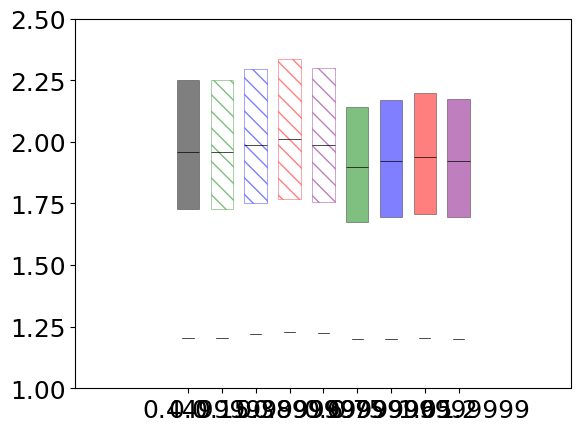

In [178]:
n_boxes = len(peak_temperatures.columns)
positions = np.arange(n_boxes) * 0.15  # smaller step = closer together

bp = plt.boxplot(
    peak_temperatures,
    widths=0.1,
    patch_artist=True,
    positions=positions,
    boxprops=dict(linewidth=0.5, color='black'),
    whiskerprops=dict(linewidth=0),#dict(linewidth=0.5, color='black'),
    capprops=dict(linewidth=0.5, color='black'),
    medianprops=dict(linewidth=0.5, color='black'),
    showfliers=False,
    showmeans=False,
)

i=0
for patch, color in zip(bp['boxes'], colors[:len(bp['boxes'])]):
    if hatches[i]=='':
        patch.set(facecolor=color, edgecolor='black',alpha=alphas[i],hatch=hatches[i])
    else:
        patch.set(facecolor='white', edgecolor=color,alpha=alphas[i],hatch=hatches[i])
        
    i=i+1
plt.ylim([1.0, 2.5])
plt.savefig('figures/Peak_temperature.pdf')

In [ ]:
# Optional: remove outlines entirely
for element in ['boxes', 'whiskers', 'caps', 'medians']:
    for item in bp[element]:
        item.set_visible(False)

# Add a small translucent percentile band (IQR)
q1, q3 = np.percentile(peak_temperatures, [25, 75])
ax.fill_betweenx([q1, q3], 0.9, 1.1, color='lightgray', alpha=0.3)

# Add a bold mean line
mean_val = np.mean(peak_temperatures)
ax.plot([0.9, 1.1], [mean_val, mean_val], color='red', linewidth=4)
